In [706]:
%autosave 0

Autosave disabled


In [707]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import unicodedata
import nltk
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

In [708]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [709]:
from nltk.tokenize import word_tokenize

In [710]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/truptaditya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [711]:
df = pd.read_csv('Airbnb_Open_Data.csv',low_memory=False)

In [712]:
#df.shape

### Airbnb Dataset Column Descriptions

- **Id** : Airbnb's unique identifier for the listing.
- **NAME** : Name of the listing (Title of the listing).
- **host id** : Airbnb's unique identifier for the host/user.
- **Host_identity_verified** : Indicates whether the host’s identity is verified. (t = true; f = false).
- **host name** : Name of the host, usually just the first name(s).
- **Neighbourhood group** : This column represents a broader geographical area or borough within the city where the property is located. Examples include "Brooklyn" and "Manhattan," which correspond to the larger boroughs of New York City.
- **Neighbourhood** : Represents a more specific area or neighborhood within the broader neighbourhood group. For example, within the neighbourhood group of "Manhattan," there are neighborhoods like "Harlem," "Midtown," and "East Harlem." Similarly, within "Brooklyn," you have neighborhoods like "Kensington" and "Clinton Hill."
- **Lat** : Latitude of the listing, using the World Geodetic System (WGS84) projection.
- **Long** : Longitude of the listing, using the World Geodetic System (WGS84) projection.
- **Country** : Country where the listing is located.
- **country code** : ISO code of the country.
- **Instant_bookable** : Indicates if the listing is instant bookable. (t = true; f = false). This means the guest can automatically book the listing without the host needing to accept the booking request, typically indicating a commercial listing.
- **Cancellation_policy** : Type of cancellation policy for the listing. Options include **strict**, **moderate**, and **flexible**.

- **room type** : Types of accommodations available. Options include:
  - **Entire home/apt**:
  - **Private room**:
  - **Shared room**:

- **Construction year** : Year the property was built.
- **Price** : Daily price in local currency per night.
- **service fee** : Additional service fee per night.
- **minimum nights** : Minimum number of nights required for a stay (calendar rules may vary).
- **number of reviews** : The total number of reviews for the listing.

- **last review** : The date of the last or most recent review. median
- **reviews per month** : Average number of reviews per month since the listing was created.
- **review rate number** : Review rating score or value associated with the listing.
- **calculated host listings count** : The total number of listings managed by the host.
- **availability 365** : Number of available days for booking within a year.
- **house_rules** : Rules and guidelines set by the host for guests.
- **License** : The license, permit, or registration number for the property, if applicable.



In [714]:
df.isna().sum()

id                                     0
NAME                                 250
host id                                0
host_identity_verified               289
host name                            406
neighbourhood group                   29
neighbourhood                         16
lat                                    8
long                                   8
country                              532
country code                         131
instant_bookable                     105
cancellation_policy                   76
room type                              0
Construction year                    214
price                                247
service fee                          273
minimum nights                       409
number of reviews                    183
last review                        15893
reviews per month                  15879
review rate number                   326
calculated host listings count       319
availability 365                     448
house_rules     

In [715]:
df.rename(columns={
    'host id': 'host_id',
    'host name': 'host_name',
    'neighbourhood group': 'neighbourhood_group',
    'room type': 'room_type',
    'Construction year': 'Construction_year',
    'service fee': 'service_fee',
    'minimum nights': 'minimum_nights',
    'number of reviews': 'number_of_reviews',
    'last review':'last_review',
    'reviews per month': 'reviews_per_month',
    'review rate number': 'review_rate_number',
    'calculated host listings count': 'calculated_host_listings_count',
    'availability 365': 'availability_365'
}, inplace=True)

In [716]:
#Drop rows that have the same id to avoid duplicate entries.
duplicate_ids = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')
duplicate_rows = duplicate_ids.index
df = df.drop(duplicate_rows)

- Cleaning NAME, host_name columns using nltk
- Reference  : https://stackoverflow.com/questions/65011034/how-does-isalnum-and-isalpha-works-in-python-returning-true-when-chinese-is-i

In [718]:
df['NAME'] = df['NAME'].fillna('').astype(str)

In [719]:
df['NAME'] = df['NAME'].apply(word_tokenize)

In [720]:
df['NAME'] = df['NAME'].apply(
    lambda tokens: [w.lower() for w in tokens if w.isascii() and w.isalpha()]
)

In [721]:
# Convert the 'NAME' column from lists to strings
df['NAME'] = df['NAME'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [722]:
# Fill blanks with a default value, e.g., "Unknown"
df['NAME'] = df['NAME'].apply(lambda x: 'Unknown' if x == [] or x == '' else x)


In [723]:
df['host_name'] = df['host_name'].fillna('').astype(str)
df['host_name'] = df['host_name'].apply(word_tokenize)
df['host_name'] = df['host_name'].apply(
    lambda tokens: [w.lower() for w in tokens if w.isascii() and w.isalpha()]
)

In [724]:
# Convert the 'host_name' column from lists to strings
df['host_name'] = df['host_name'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Fill blanks with a default value, e.g., "Unknown"
df['host_name'] = df['host_name'].apply(lambda x: 'Unknown' if x == [] or x == '' else x)


In [725]:
pd.set_option('display.max_column',50)
pd.set_option('display.max_row',30)

In [726]:
df.shape

(101517, 26)

In [727]:
#df.isna().sum()

 **Drop `country`,`country code`,`license`,`house_rules` Columns**  
   - Since `country` and `country code` columns contain only one unique value (e.g., "United States" and "US"), they provide little informational value and can be removed
 **Drop the `license` Column**  
   - Drop the `license` column it has Nans more than threshold
   - Drop the `house_rules` column it has Nans more than threshold

In [729]:
columns_to_drop = ['country code', 'country','license','house_rules']
df.drop(columns=columns_to_drop, inplace=True)

- Drop all the rows that has nan < 500
- neighbourhood_group, neighbourhood, lat, long, cancellation_policy, instant_bookable, host_identity_verified
  Construction_year, calculated_host_listings_count, review_rate_number, number_of_reviews

In [731]:
df.dropna(how='any',subset=['neighbourhood_group'],inplace=True)

In [732]:
df.dropna(how='any',subset=['neighbourhood'],inplace=True)

In [733]:
df.dropna(how='any',subset=['lat'],inplace=True)

In [734]:
df.dropna(how='any',subset=['long'],inplace=True)

In [735]:
df.dropna(how='any',subset=['cancellation_policy'],inplace=True)

In [736]:
df.dropna(how='any',subset=['instant_bookable'],inplace=True)

In [737]:
df.dropna(how='any',subset=['host_identity_verified'],inplace=True)

In [738]:
df.dropna(how='any',subset=['Construction_year'],inplace=True)

In [739]:
df.dropna(how='any',subset=['calculated_host_listings_count'],inplace=True)

In [740]:
df.dropna(how='any',subset=['review_rate_number'],inplace=True)

In [741]:
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)

#### Standardization:

In [743]:
# Convert all values to title case
df['neighbourhood_group'] = df['neighbourhood_group'].str.title()

# Define a mapping dictionary for common typos
neighbourhood_corrections = {
    'Brookln': 'Brooklyn',
    'Manhatan': 'Manhattan'
}

# Replace typos based on the mapping
df['neighbourhood_group'] = df['neighbourhood_group'].replace(neighbourhood_corrections)


In [744]:
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)
price_avg = df.price.mean()
df.fillna({'price': price_avg} , inplace=True)
# Round to 2 decimal places
df['price'] = df['price'].round(2)

In [745]:
df['service_fee'] = df['service_fee'].replace('[$,]', '', regex=True).astype(float)
service_fee_avg = df.service_fee.mean()
df.fillna({'service_fee': price_avg} , inplace=True)
# Round to 2 decimal places
df['service_fee'] = df['service_fee'].round(2)

In [746]:
# Convert the 'last_review' column to datetime yyyy-mm-dd
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Calculate the median
median_date = df['last_review'].median()  # Median datetime
df['last_review'] = df['last_review'].fillna(median_date)
df.loc[df['last_review'] > '2024-06-30', 'last_review'] = median_date

In [747]:
median_reviews_per_month= df['reviews_per_month'].median()
df.fillna({'reviews_per_month': median_reviews_per_month} , inplace=True)

In [748]:
#Mean
minimum_nights_mean = round(df['minimum_nights'].mean())
#fill nan and values less than 0
df.fillna({'minimum_nights':minimum_nights_mean}, inplace=True)
df.loc[df['minimum_nights'] < 0, 'minimum_nights']= minimum_nights_mean

In [749]:
# availability 365 : Number of available days for booking within a year. That means The range of values should be >= 0 to <=365
# Filling NaN with 0
df['availability_365'] = df['availability_365'].fillna(0)

# Filling negative values with 0
df.loc[df['availability_365'] < 0, 'availability_365'] = 0

# Filling values greater than 365 with mean()
availability_365_mean = round(df['availability_365'].mean())

df.loc[df['availability_365'] > 365, 'availability_365'] = availability_365_mean


In [750]:
df.isna().sum()

id                                0
NAME                              0
host_id                           0
host_identity_verified            0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
lat                               0
long                              0
instant_bookable                  0
cancellation_policy               0
room_type                         0
Construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

# Command line Analysis

In [752]:
df_command = df.copy()

### Top neighbourhood_group by listings
- `Manhattan` is the most popular neighbourhood_group
- `Brooklyn` is the 2nd most popular neighbourhood_group
- In `room_type` category, Entire home/apt type has highest count and Private room has 2nd highest count
- `room_type` = Entire home/apt,  Shared room , Hotel room "Manhattan" is top most
- Brooklyn has highest count of `room_type` =  Private room

In [754]:
df_command['neighbourhood_group'].value_counts()

neighbourhood_group
Manhattan        42841
Brooklyn         40936
Queens           13023
Bronx             2641
Staten Island      932
Name: count, dtype: int64

In [755]:
df_command.groupby(['neighbourhood_group','room_type'])['neighbourhood'].count().sort_values(ascending=False).head()

neighbourhood_group  room_type      
Manhattan            Entire home/apt    25908
Brooklyn             Entire home/apt    20127
                     Private room       19991
Manhattan            Private room       15960
Queens               Private room        7607
Name: neighbourhood, dtype: int64

#### Top neighbourhood
-`neighbourhood` = Bedford-Stuyvesant and Williamsburg  in Brooklyn

In [757]:
df_command.groupby(['neighbourhood_group','neighbourhood'])['neighbourhood'].count().sort_values(ascending=False)

neighbourhood_group  neighbourhood         
Brooklyn             Bedford-Stuyvesant        7778
                     Williamsburg              7588
Manhattan            Harlem                    5330
Brooklyn             Bushwick                  4883
Manhattan            Hell's Kitchen            3901
                                               ... 
Staten Island        Willowbrook                  3
                     Woodrow                      3
                     Fort Wadsworth               2
Queens               Glen Oaks                    2
Staten Island        Chelsea, Staten Island       1
Name: neighbourhood, Length: 224, dtype: int64

#### Neighbourhood with top rated listing

In [759]:
df_command.groupby(['neighbourhood_group','neighbourhood'])['review_rate_number'].mean().sort_values(ascending=False)

neighbourhood_group  neighbourhood         
Queens               Glen Oaks                 4.500000
Bronx                Co-op City                4.400000
Brooklyn             Gerritsen Beach           4.333333
Staten Island        Huguenot                  4.111111
                     Woodrow                   4.000000
                                                 ...   
                     Tottenville               2.384615
                     Fort Wadsworth            2.000000
                     Chelsea, Staten Island    2.000000
                     Willowbrook               2.000000
                     Howland Hook              1.666667
Name: review_rate_number, Length: 224, dtype: float64

- For each neighbourhood_group, count of listings that have the maximum price within their group.

In [761]:
max_price = df_command.groupby('neighbourhood_group').apply(lambda d: \
            d[d.price == d.price.max()], include_groups = False) 

max_price.groupby('neighbourhood_group')['id'].count().sort_values(ascending=False)

neighbourhood_group
Brooklyn         33
Manhattan        21
Queens            9
Bronx             4
Staten Island     1
Name: id, dtype: int64

- Good listings are those which have review_rate_number > 4 , reviews_per_month and number_of_reviews > respective averages
- Hidden gems are those with lower priced listings within good listings

In [763]:

reviews_per_month_mean = df_command['reviews_per_month'].mean()
number_of_reviews_mean = df_command['number_of_reviews'].mean()
# Filter the good listings
good_listings = df_command[(df_command['review_rate_number']> 4) & (df_command['reviews_per_month'] > reviews_per_month_mean) &  (df_command['number_of_reviews'] > number_of_reviews_mean)]
Hidden_gems = good_listings.sort_values(by='price',ascending=True)
Hidden_gems.head(5)

id                                              NAME  \
28643  16820865  spacious bed private bath in renovated townhouse   
61234  34820874                    a private humble abode for you   
10029   6540353                           carroll gardens retreat   
71862  40690719                           carroll gardens retreat   
29725  17418454                cozy place in astoria to manhattan   

           host_id host_identity_verified         host_name  \
28643  44124485794               verified  caroline adriaan   
61234   4833155663            unconfirmed            sandra   
10029  28596740395               verified            gianni   
71862  38736421743               verified            gianni   
29725  77973791529               verified             jewel   

      neighbourhood_group     neighbourhood       lat      long  \
28643            Brooklyn     Crown Heights  40.67096 -73.95261   
61234            Brooklyn          Canarsie  40.64030 -73.89549   
10029            Brooklyn   Carroll Gardens  40.68167 -73.99276   
71862            Brooklyn   Carroll Gardens  40.68167 -73.99276   
29725              Queens  Long Island City  40.75533 -73.93261   

      instant_bookable cancellation_policy        room_type  \
28643             True            moderate     Private room   
61234            False              strict     Private room   
10029             True            moderate  Entire home/apt   
71862             True            flexible  Entire home/apt   
29725            False            moderate  Entire home/apt   

       Construction_year  price  service_fee  minimum_nights  \
28643             2017.0   50.0         10.0             2.0   
61234             2011.0   50.0         10.0             2.0   
10029             2016.0   52.0         10.0             4.0   
71862             2016.0   52.0         10.0             4.0   
29725             2006.0   53.0         11.0             2.0   

       number_of_reviews last_review  reviews_per_month  review_rate_number  \
28643               34.0  2019-06-30               2.12                 5.0   
61234              136.0  2021-12-13               1.52                 5.0   
10029               96.0  2019-05-19               2.02                 5.0   
71862               96.0  2019-05-19               2.02                 5.0   
29725               45.0  2019-06-22               2.84                 5.0   

       calculated_host_listings_count  availability_365  
28643                             1.0             127.0  
61234                             1.0             364.0  
10029                             2.0               0.0  
71862                             2.0               3.0  
29725                             1.0              33.0

In [764]:
from nltk.corpus import stopwords
nltk.download('stopwords')
df_token = df.copy()
df_token['POPULAR_WORDS'] = df_token['NAME'].apply(word_tokenize)
# Flatten tokenized words into a single column using explode
all_words = df_token['POPULAR_WORDS'].explode()


#type(all_words)
# Count word frequencies
word_frequencies = all_words.value_counts()
#word_frequencies.nlargest(30)
# Get English stopwords
stop_words = set(stopwords.words('english'))
# removing the irrelevant word
stop_words.add("room")
stop_words.add("apartment")
stop_words.add("bedroom")
stop_words.add("apt")
stop_words.add("studio")
stop_words.add("brooklyn")
stop_words.add("manhattan")
stop_words.add("east")



# Remove stopwords from the tokenized words
filtered_words = all_words[~all_words.isin(stop_words)]
#type(stop_words)
# Count word frequencies again
filtered_word_frequencies = filtered_words.value_counts()
#filtered_words
filtered_word_frequencies.head(5)
#df_token.head(10)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/truptaditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

POPULAR_WORDS
private     15280
cozy        10404
spacious     7446
park         6249
sunny        5582
Name: count, dtype: int64

- The most used words in describing the listings are private, cozy and spacious
- We used nltk library to discard stopwords (non relevant words)
- We added stopwords which are not relevant describing the listings

## Project Overview :
- This project aimed discovering focus areas in terms of achieving higher profit, demand and marketinng strtegies.
- Our main focus area are Price reviews, neighborhood and review patterns


# Finding 1 
<div class="alert alert-block alert-success">  Actionable Pricing Adjustment Recommendations for AirBnb listing owners for increasing revenue. </div>

In [768]:
df_map = df_command[(df_command['review_rate_number'] == 5.0) | (df_command['review_rate_number'] == 1.0)]
#df_map

<Axes: xlabel='number_of_reviews', ylabel='price'>

Text(0.5, 1.0, 'Price Distribution Based on Review Rating')

Text(0.5, 0, 'Reviews Rate ')

Text(0, 0.5, 'Price')

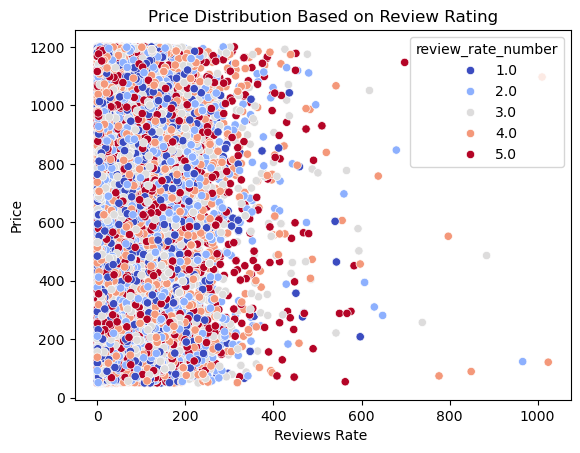

In [769]:
sns.scatterplot(data=df_command, x='number_of_reviews', y='price', hue='review_rate_number', palette='coolwarm')
plt.title('Price Distribution Based on Review Rating')
plt.xlabel('Reviews Rate ')
plt.ylabel('Price')
plt.show()

##### Distribution of price and review rating
- This scatter graph shows distribution of price and review rating.
- There are listings which have high ratings however their prices are low.
- Similarly there are listings which have low ratings while their prices are high.
- This observation can be used for making Actionable recommendations to the listing owners.

In [771]:
# Correlation of price with other metrics
correlation_price = df_command[['price', 'review_rate_number', 'reviews_per_month']].corr()

correlation_price

price  review_rate_number  reviews_per_month
price               1.000000           -0.004989           0.004173
review_rate_number -0.004989            1.000000           0.034664
reviews_per_month   0.004173            0.034664           1.000000

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

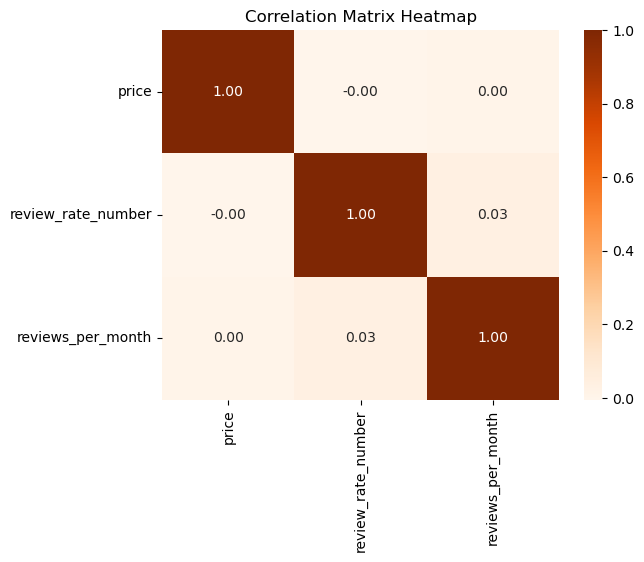

In [772]:
# Heatmap of Correlation Matrix
sns.heatmap(correlation_price, annot=True, fmt=".2f", cmap='Oranges')
plt.title("Correlation Matrix Heatmap")
plt.show()

##### This heatmap confirms on visual finding that there is no correlation between price and review

#### Now we analyze the potential listings whose prices can be adjusted
- Trustworthy ratings: Rating are trustworthy when their per month review and total review count is high, therefore we are focusing on reviews_per_month, number_of_reviews. We select only those listings with above average reviews_per_month and number_of_reviews.
 
- Highly Acclaimed listings: Those listings with high ratings above 4 

#### Actionable Pricing Adjustment Recommendations for AirBnb listing owners for increasing revenue.
- We have identified listings that are doing consistently well but are priced lower than their neighborhood price. We recommend increasing their price by comparing them to relevant neighbouring listings by providing exact increases to achieve higher profit.

In [776]:
reviews_per_month_mean = df_command['reviews_per_month'].mean()
number_of_reviews_mean = df_command['number_of_reviews'].mean()
acclaimed_listings = df_command[(df_command['review_rate_number']> 4) & (df_command['reviews_per_month'] > reviews_per_month_mean) &  (df_command['number_of_reviews'] > number_of_reviews_mean)]

- Next, we identify listings from acclaimed listings that are priced lower than the average price in the neighborhood and property type.
- Here the column price_delta is recommended price increase for Highly Acclaimed listings

In [778]:
# Group by key attributes and compare averages
comparison_attributes = ['neighbourhood', 'room_type']

# Aggregate statistics for comparison
attribute_comparison = acclaimed_listings.groupby(comparison_attributes).size().reset_index(name='Count').sort_values(by = 'Count', ascending = False)
price_mean = acclaimed_listings.groupby(comparison_attributes)['price'].mean()
acclaimed_listings['group_price_mean'] = acclaimed_listings.set_index(comparison_attributes).index.map(price_mean)

# Calculate the delta between price and group_price_mean
acclaimed_listings['price_delta'] = acclaimed_listings['group_price_mean'] - acclaimed_listings['price']

#acclaimed_listings
price_increase_recommendations = acclaimed_listings[acclaimed_listings.price_delta > 0]

#price_increase_recommendations
selected_columns = price_increase_recommendations[['id', 'NAME','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price','group_price_mean','price_delta']]
selected_columns

id                                               NAME  \
54       1031160                        greenpoint place has it all   
139      1078106                                    flat macdonough   
218      1121737                    city room private comfy bedroom   
258      1143829  safe cute near subway manhattan ny ny retro style   
298      1165921      designer br loft in carroll gardens by subway   
...          ...                                                ...   
101954  57310530    sweet and secluded suite minutes from manhattan   
101977  57323233            spacious room in front of prospect park   
102007  57339802      prospect park apt min to soho min from trains   
102022  57348087               spacious bedroom park slope brooklyn   
102050  57363551        sunny brownstone studio in bedstuy brooklyn   

            host_id         host_name neighbourhood_group  \
54      52857769781          madaline            Brooklyn   
139     12359551036         frederick            Brooklyn   
218     38264908739          morrison           Manhattan   
258      3323425751             perry              Queens   
298     70108456652              ryan            Brooklyn   
...             ...               ...                 ...   
101954  11375318185  omar and kareema            Brooklyn   
101977    934503023             emmie            Brooklyn   
102007  92706352765                mo            Brooklyn   
102022  59244531460              erik            Brooklyn   
102050  11145329848             jamal            Brooklyn   

                    neighbourhood        room_type   price  group_price_mean  \
54                     Greenpoint  Entire home/apt  254.00        545.055556   
139            Bedford-Stuyvesant  Entire home/apt  593.00        658.077552   
218                        Harlem     Private room  220.00        626.359712   
258                       Astoria  Entire home/apt  545.00        604.902439   
298               Carroll Gardens  Entire home/apt  523.00        650.478261   
...                           ...              ...     ...               ...   
101954                   Bushwick  Entire home/apt  406.00        575.709302   
101977  Prospect-Lefferts Gardens     Private room  259.00        654.448276   
102007  Prospect-Lefferts Gardens  Entire home/apt  420.00        504.825000   
102022                 Park Slope     Private room  514.00        795.894737   
102050         Bedford-Stuyvesant  Entire home/apt  625.49        658.077552   

        price_delta  
54       291.055556  
139       65.077552  
218      406.359712  
258       59.902439  
298      127.478261  
...             ...  
101954   169.709302  
101977   395.448276  
102007    84.825000  
102022   281.894737  
102050    32.587552  

[2266 rows x 10 columns]

- We identified 2266 highly acclaimed listings whose prices are below neighborhood average. We also determine the price point that they can achieve using the price_delta calculated by actual price and average price.
- price_delta reflects the recommended price needs to be added in the original price to earn more profit.
  
- We assume that listing price is lower due to less amenities and services, this information gives indication how much they can invest to acheive higher profit.

#####  Identify listings with low ratings but are priced higher than their higher rated counterparts.
- Next we look at listings with lower ratings

In [781]:
lower_rated_listing = df_command[(df_command['review_rate_number']< 3) & (df_command['reviews_per_month'] > reviews_per_month_mean) &  (df_command['number_of_reviews'] > number_of_reviews_mean)]
# Group by key attributes and compare averages
comparison_attributes_bl = ['neighbourhood', 'room_type']
attribute_comparison_bl = lower_rated_listing.groupby(comparison_attributes).size().reset_index(name='Count').sort_values(by = 'Count', ascending = False)
price_mean_bl = lower_rated_listing.groupby(comparison_attributes)['price'].mean()
lower_rated_listing['group_price_mean_bl'] = lower_rated_listing.set_index(comparison_attributes).index.map(price_mean)
# Calculate the delta between price and group_price_mean
lower_rated_listing['price_delta_bl'] = lower_rated_listing['price'] - lower_rated_listing['group_price_mean_bl'] 
recommendation_lower_rating = lower_rated_listing[lower_rated_listing.price_delta_bl > 0]


# List of columns you want to see
selected_columns = ['id', 'NAME', 'neighbourhood', 'room_type', 'price', 'group_price_mean_bl', 'price_delta_bl']
#lower_rated_listing
selected_columns = recommendation_lower_rating[['id', 'NAME','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price','group_price_mean_bl','price_delta_bl']]
selected_columns

id                                            NAME      host_id  \
109      1061537                      sq foot in luxury building  18044628997   
133      1074792                 nyc artists loft with roof deck  48867545848   
145      1081420                          flat macdonough garden  64718456383   
236      1131679                                         Unknown  74291995690   
256      1142725   brooklyn guest room queen bed in williamsburg  97374363906   
...          ...                                             ...          ...   
102001  57336488                                    cozy bedroom  57252753267   
102003  57337593               special cozy waterfront apartment  77042850099   
102014  57343668       coney island amphitheat mcu br wifi cable  38171814589   
102039  57357476  spacious two bedrooms condo in upper manhattan  14430571516   
102040  57358028                      room in queens ny near lga  56457739998   

         host_name neighbourhood_group       neighbourhood        room_type  \
109           emma           Manhattan              Harlem     Private room   
133       lilianna            Brooklyn          Greenpoint     Private room   
145           ryan            Brooklyn  Bedford-Stuyvesant  Entire home/apt   
236        cameron           Manhattan         East Harlem  Entire home/apt   
256     richardson            Brooklyn        Williamsburg     Private room   
...            ...                 ...                 ...              ...   
102001     Unknown           Manhattan     Upper East Side  Entire home/apt   
102003     Unknown              Queens    Ditmars Steinway  Entire home/apt   
102014          ed            Brooklyn        Coney Island  Entire home/apt   
102039         max           Manhattan              Inwood  Entire home/apt   
102040       sonia              Queens       East Elmhurst     Private room   

         price  group_price_mean_bl  price_delta_bl  
109      839.0           626.359712      212.640288  
133     1125.0           778.333333      346.666667  
145      853.0           658.077552      194.922448  
236     1052.0           630.013889      421.986111  
256     1164.0           602.512500      561.487500  
...        ...                  ...             ...  
102001   845.0           479.774194      365.225806  
102003   729.0           620.043478      108.956522  
102014   984.0           589.000000      395.000000  
102039   665.0           101.500000      563.500000  
102040   982.0           773.027027      208.972973  

[3192 rows x 10 columns]

- We have identified 3192 listings with low ratings but are priced higher than their neighborhood price. The listing price is higher because of improper pricing. These findings give indication how much they can reduce the price to achieve optimal rating and profit.
- The price in column price_delta_bl give indication how much they can reduce from the original price to achieve optimal rating and profit.

#### Actionable insight : Price adjustments should be considered based calculated price delta which is based on neighborhood mean.

# Graphical Analysis

### Distribution of Airbnb Prices 
- `Graph Type`: Histogram 
- `Purpose`: To visualize the distribution of Airbnb listing prices.
- `X-axis`: Price of Airbnb listings in dollars ($).
- `Bins`: 50 intervals for a clearer price distribution view.
- `Observation`: The price distribution appears relatively uniform with occasional peaks. 

In [785]:
df_graph = df.copy()

<Axes: >

Text(0.5, 1.0, 'Distribution of Airbnb Prices')

Text(0.5, 0, 'Price ($)')

Text(0, 0.5, 'Frequency')

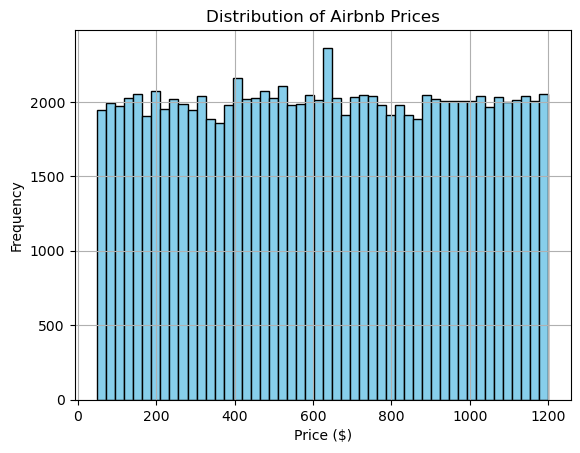

In [786]:
df_graph['price'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

### Average Airbnb Prices Across Neighbourhood Groups

- `Graph Type`: Bar Chart
- `Purpose`: To To compare the average price of Airbnb listings across neighbourhood groups.
- `X-axis`: Neighborhood groups (Bronx, Brooklyn, Manhattan, Queens, Staten Island).
- `Y-axis`: Average price of Airbnb listings in dollars ($).
- `Observation`: All neighborhood groups have similar average prices, with no significant differences. 

<Axes: xlabel='neighbourhood_group'>

Text(0.5, 1.0, 'Average Airbnb Prices Across Neighbourhood Groups')

Text(0.5, 0, 'neighbourhood_group')

Text(0, 0.5, 'Price')

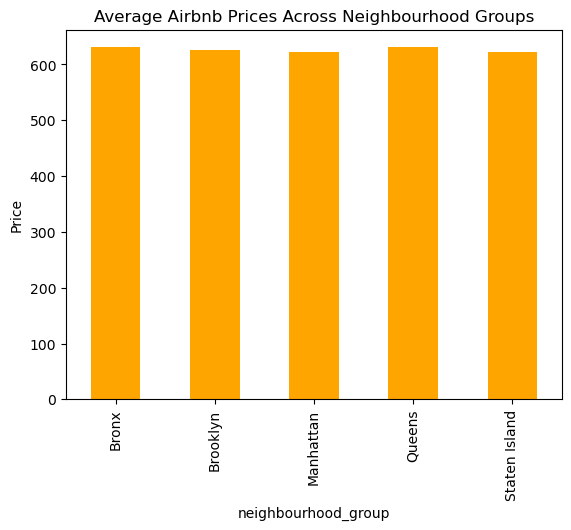

In [789]:
df_graph.groupby('neighbourhood_group')['price'].mean().plot(kind='bar', color='orange')
plt.title('Average Airbnb Prices Across Neighbourhood Groups')
plt.xlabel('neighbourhood_group')
plt.ylabel('Price')

All neighbourhood groups have similar average prices, with no significant differences. 

# Finding 2 
<div class="alert alert-block alert-success"> Identification of Medium-Profitability Neighbourhood </div>

In [792]:
df_find = df.copy()

### Classify Neighbourhood by Profitability 

##### Classify neighborhood as Low, Medium, or High profitability based on average revenue 
We use 

Estimated Revenue = price * (365 - availability_365) indicating profit from the bookings

giving a realistic measure of its potential earning. 
This ensure profitability reflects both pricing and operational activity, providing a more accurate classification of neighbourhood performance.

In [795]:
#Calculate estimated revenue for each listing
df_find['estimated_revenue'] = df_find['price'] * (365 - df_find['availability_365'])

# Group by neighbourhood and calculate the average estimated revenue
neighbourhood_revenue = df_find.groupby('neighbourhood', as_index=False)['estimated_revenue'].mean()


# Classify neighbourhood into Low, Medium and High profitability
neighbourhood_revenue['profitability']= pd.cut(
    neighbourhood_revenue['estimated_revenue'], 
    bins=[10000, 110000, 125000, float('inf')], 
    labels=['Low','Medium','High']
)
neighbourhood_revenue.sort_values(by='estimated_revenue', ascending = False)

neighbourhood  estimated_revenue profitability
144                New Dorp      357583.000000          High
222                 Woodrow      231869.333333          High
35   Chelsea, Staten Island      209442.000000          High
179             Shore Acres      204709.222222          High
119             Little Neck      201919.500000          High
..                      ...                ...           ...
211              West Farms       29022.833333           Low
21             Breezy Point       26974.666667           Low
218             Willowbrook        7480.000000           NaN
86                Glen Oaks        1231.500000           NaN
83           Fort Wadsworth           0.000000           NaN

[224 rows x 3 columns]

In [796]:

# Group by neighbourhood and calculate the average estimated revenue
neighbourhood_group_revenue = df_find.groupby('neighbourhood_group', as_index=False)['estimated_revenue'].mean()

# Classify neighbourhood into Low, Medium and High profitability
neighbourhood_group_revenue['profitability']= pd.cut(
    neighbourhood_group_revenue['estimated_revenue'], 
    bins=[10000, 110000, 125000, float('inf')], 
    labels=['Low','Medium','High']
)
neighbourhood_group_revenue.sort_values(by = 'estimated_revenue', ascending = False)

neighbourhood_group  estimated_revenue profitability
1            Brooklyn      152169.972926          High
2           Manhattan      144350.439038          High
3              Queens      131546.433872          High
0               Bronx      119141.342154        Medium
4       Staten Island      107089.264227           Low

This step calculates the estimated revenue for each Airbnb listing and classifies neighborhoods into profitability categories.

`pd.cut()` divides neighborhoods into three categories based on their average estimated revenue:

**Low**: Revenue between $0 and $50,000

**Medium**: Revenue between $50,000 and $150,000

**High**: Revenue above $150,000

**Labels**: `'Low'`, `'Medium'`, `'High'`

**Purpose**: This step helps identify which neighborhoods have low, medium, or high profitability.

This classification allows for strategic analysis, highlighting opportunities for improvement 

#### Bar Chart of Average Revenue by Neighbourhood

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Top 10 Neighbourhoods by Estimated Revenue')

Text(0.5, 0, 'Estimated Revenue($)')

Text(0, 0.5, 'Neighbourhood')

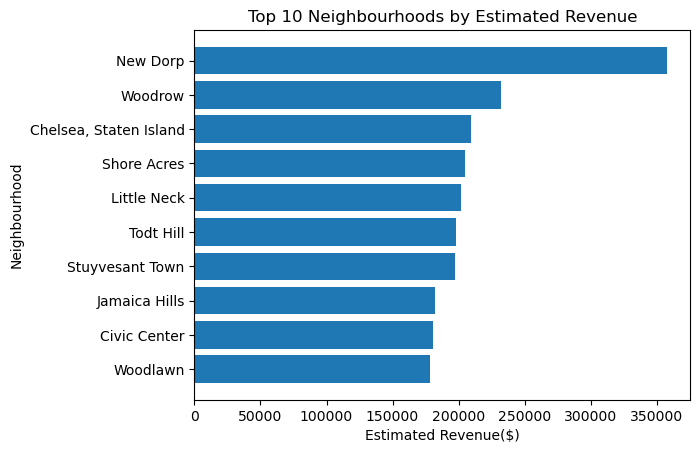

In [799]:
top_neighbourhood = neighbourhood_revenue.sort_values(by 
                        = 'estimated_revenue', ascending = False).head(10)
plt.barh(top_neighbourhood['neighbourhood'], top_neighbourhood['estimated_revenue'])
plt.title('Top 10 Neighbourhoods by Estimated Revenue')
plt.xlabel('Estimated Revenue($)')
plt.ylabel('Neighbourhood')
plt.gca().invert_yaxis() # Invert to show the highest at the top
plt.show()

This bar chart shows the **Top 10 neighbourhoods by estimated revenues**. 
- New Drop stands out as the highest revenue-generating neighbourhood, significantly surpassing others.

### Impact of Instant Booking on Estimated Revenue

In [802]:
df_find.groupby('instant_bookable')['estimated_revenue'].mean()

instant_bookable
False    144203.101030
True     145540.422665
Name: estimated_revenue, dtype: float64

<Axes: xlabel='instant_bookable', ylabel='estimated_revenue'>

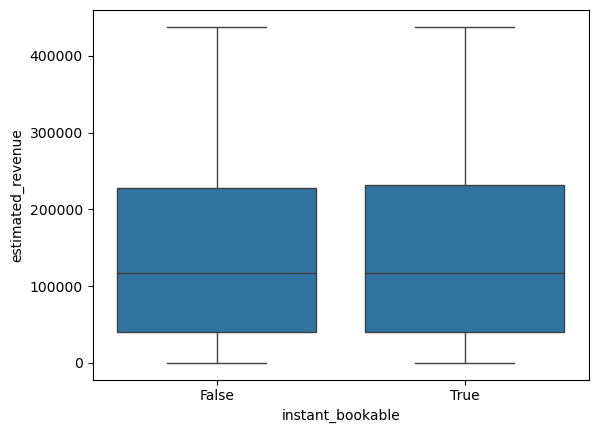

In [803]:
sns.boxplot(x='instant_bookable', y='estimated_revenue', data=df_find)

This boxplot compares estimated revenue for listings with instant booking enabled (True) versus disabled (False).

`X-axis`: Instant booking status.
`Y-axis`: Estimated revenue.

**Key Observations**:
The median estimated revenue is nearly identical for both categories.
Both groups show similar interquartile ranges (IQR) and overall revenue distributions.
There are outliers in both categories, but they do not significantly impact the central trend.

**Reason to Exclude**:
Lack of significant difference: The analysis shows that enabling or disabling instant booking has no clear impact on estimated revenue.
The minimal variation does not provide actionable insights for improving profitability, so this factor was not prioritized in further analysis.

In [806]:
neighbourhood_group_revenue.sort_values(by = 'estimated_revenue', ascending = False)

neighbourhood_group  estimated_revenue profitability
1            Brooklyn      152169.972926          High
2           Manhattan      144350.439038          High
3              Queens      131546.433872          High
0               Bronx      119141.342154        Medium
4       Staten Island      107089.264227           Low

This step calculates the estimated revenue for each Airbnb listing and classifies neighborhoods into profitability categories.

`pd.cut()` divides neighborhoods into three categories based on their average estimated revenue:

**Low**: Revenue between $0  -  $10,000

**Medium**: Revenue between $10,000 - $110,000

**High**: Revenue above $125,000

**Labels**: `'Low'`, `'Medium'`, `'High'`

**Purpose**: This step helps identify which neighborhoods have low, medium, or high profitability.

This classification allows for strategic analysis, highlighting opportunities for improvement 

In [808]:
# Filter Medium profitability neighbourhoods
medium_potential = neighbourhood_revenue[
    (neighbourhood_revenue['profitability'] == 'Medium') &
    (neighbourhood_revenue['estimated_revenue'] >= 10000)
]

In [809]:
medium_potential.sort_values(by= 'estimated_revenue', ascending = False)

neighbourhood  estimated_revenue profitability
189      St. George      124641.357724        Medium
195     Throgs Neck      124578.462963        Medium
157  Pelham Gardens      124530.162162        Medium
150         Norwood      123286.756757        Medium
78         Flushing      123209.165368        Medium
..              ...                ...           ...
151         Oakwood      111701.714286        Medium
56     Dongan Hills      111536.846154        Medium
20     Borough Park      111178.425396        Medium
24        Bronxdale      110620.881136        Medium
124     Marble Hill      110021.071429        Medium

[38 rows x 3 columns]

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='estimated_revenue', ylabel='neighbourhood'>

Text(0.5, 1.0, 'Top 5 Medium Profitability Neighbourhoods Close to High')

Text(0.5, 0, 'Estimated Revenue($)')

Text(0, 0.5, 'Neighbourhood')

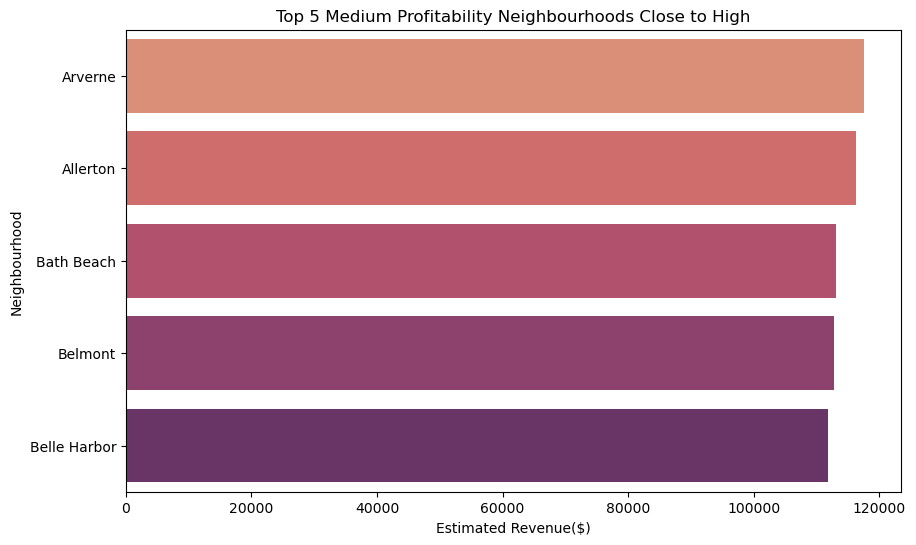

In [810]:
top_5_medium = medium_potential.head(5).sort_values(by = 'estimated_revenue', ascending = False)
plt.figure(figsize= (10, 6))
sns.barplot(
    x = 'estimated_revenue',
    y = 'neighbourhood',
    data = top_5_medium, 
    hue = 'neighbourhood',
    dodge = False,
    palette = 'flare',
    legend = False
)
plt.title('Top 5 Medium Profitability Neighbourhoods Close to High')
plt.xlabel('Estimated Revenue($)')
plt.ylabel('Neighbourhood')

#### Medium Profitable neighbourhoods 

In [812]:
# Filter the dataset for the top neighborhoods
top_neighborhoods = ['Arverne','Allerton','Bath Beach', 'Belmont', 'Belle Harbor']
# Check their neighborhood groups
df_find[df_find['neighbourhood'].isin(top_neighborhoods)][['neighbourhood', 'neighbourhood_group']].drop_duplicates()

neighbourhood neighbourhood_group
511        Allerton               Bronx
1328        Arverne              Queens
5994   Belle Harbor              Queens
12193       Belmont               Bronx
19110    Bath Beach            Brooklyn

In [813]:
# Sort by the custom order in 'top_neighborhoods'
df_find[df_find['neighbourhood'].isin(top_neighborhoods)][['neighbourhood', 'neighbourhood_group']]\
  .drop_duplicates()\
  .sort_values(by='neighbourhood', key=lambda x: pd.Categorical(x, categories=top_neighborhoods, ordered=True))

neighbourhood neighbourhood_group
1328        Arverne              Queens
511        Allerton               Bronx
19110    Bath Beach            Brooklyn
12193       Belmont               Bronx
5994   Belle Harbor              Queens

**Insight 2**: The key finding is that certain **Medium profitability neighbourhood**, such as Arverne, Allerton, and Bath Beach are close to becoming **High profitability**. These neighbourhoods represents untapped potential and opportunities for growth with target strategies. 

**Actionable Point**: 
Dynamic Pricing strategies. Adjust pricing models based on market demand to optimize revenue during peak seasons.

# Finding 3 (Decision Tree)
<div class="alert alert-block alert-success"> Correlation Analysis </div>

- Analytics Steps
- Encoded neighborhood groups into binary columns for modeling.
- Selected features: availability, price, reviews, and neighborhood groups.
- Split data into 70% training and 30% testing sets.
- Trained a decision tree with a maximum depth of 2.
- Visualized the tree to reveal key trends.


In [817]:
df_dt = df.copy()

DecisionTreeClassifier(max_depth=2, random_state=42)

<Figure size 1500x700 with 0 Axes>

[Text(0.5, 0.8333333333333334, 'neighbourhood_group_Manhattan <= 0.5\ngini = 0.52\nsamples = 70261\nvalue = [36801.0, 73.0, 31853.0, 1534.0]\nclass = Private room'),
 Text(0.25, 0.5, 'number_of_reviews <= 3.5\ngini = 0.521\nsamples = 40256\nvalue = [18681, 10, 20639, 926]\nclass = Shared room'),
 Text(0.125, 0.16666666666666666, 'gini = 0.514\nsamples = 14217\nvalue = [5592.0, 1.0, 8167.0, 457.0]\nclass = Shared room'),
 Text(0.375, 0.16666666666666666, 'gini = 0.518\nsamples = 26039\nvalue = [13089, 9, 12472, 469]\nclass = Private room'),
 Text(0.75, 0.5, 'number_of_reviews <= 32.5\ngini = 0.495\nsamples = 30005\nvalue = [18120, 63, 11214, 608]\nclass = Private room'),
 Text(0.625, 0.16666666666666666, 'gini = 0.481\nsamples = 23901\nvalue = [15048.0, 36.0, 8358.0, 459.0]\nclass = Private room'),
 Text(0.875, 0.16666666666666666, 'gini = 0.527\nsamples = 6104\nvalue = [3072.0, 27.0, 2856.0, 149.0]\nclass = Private room')]

Text(0.5, 1.0, 'Decision Tree to Predict Room Type')

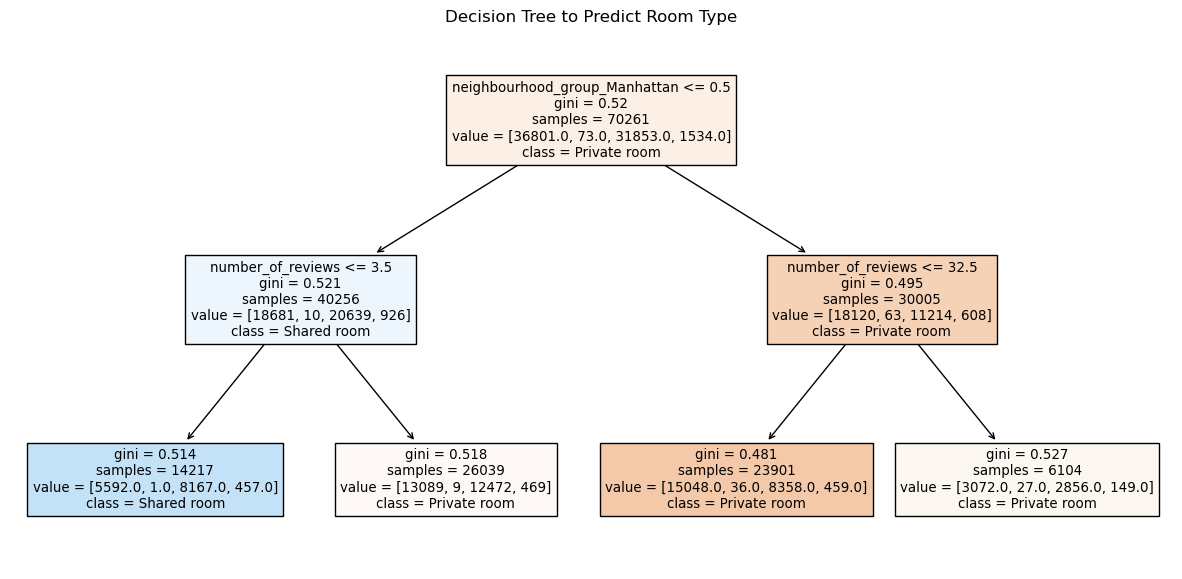

In [818]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: One-Hot Encode the categorical column 'neighbourhood_group'
df_dt = pd.get_dummies(df, columns=['neighbourhood_group'], drop_first=True)

# Step 2: Define features and target
features = [ 'price', 'number_of_reviews'] + [col for col in df_dt.columns if 'neighbourhood_group_' in col]
target = 'room_type'

# Step 4: Train-test split 
X = df_dt[features]
y = df_dt[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train the decision tree
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Visualize the decision tree
plt.figure(figsize=(15, 7))
plot_tree(clf, feature_names=features, class_names=df_dt['room_type'].unique(), filled=True)
plt.title('Decision Tree to Predict Room Type')
plt.show() 

- Tree Breakdown
- Root Split: Listings split by neighborhood group (e.g., Manhattan).
- Non-Manhattan: Fewer than 3.5 reviews likely shared rooms.
- Manhattan: Fewer than 32.5 reviews likely private rooms.
- Final Trends: High reviews in both groups favor private rooms but differ in certainty.



<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='room_type', ylabel='count'>

Text(0.5, 1.0, 'Room Type Distribution in Manhattan')

Text(0.5, 0, 'Manhattan (1=True, 0=False)')

Text(0, 0.5, 'Count of Listings')

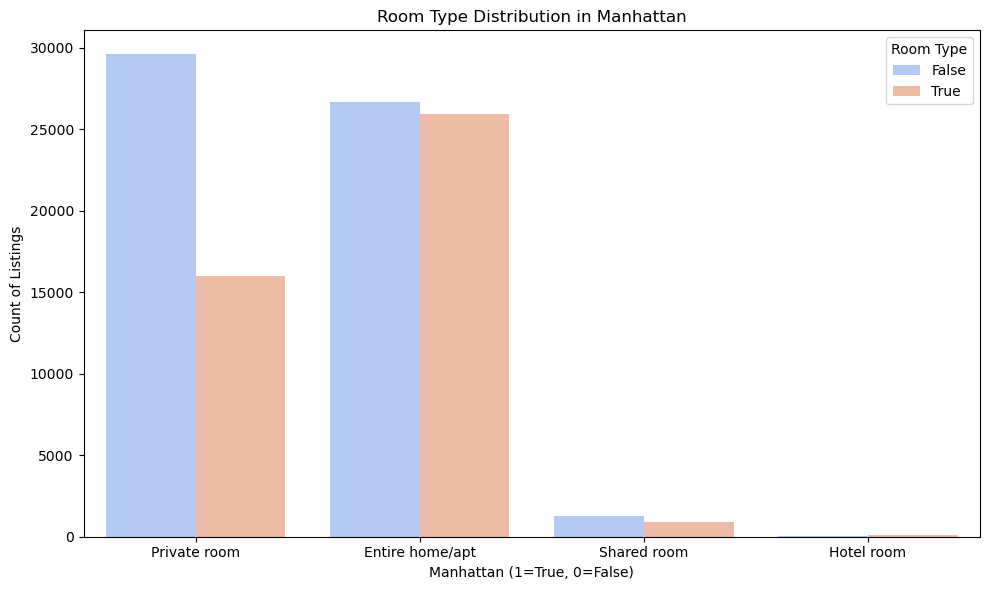

In [820]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.countplot(data=df_dt, x='room_type', hue='neighbourhood_group_Manhattan', palette="coolwarm")
plt.title("Room Type Distribution in Manhattan")
plt.xlabel("Manhattan (1=True, 0=False)")
plt.ylabel("Count of Listings")
plt.legend(title="Room Type")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='room_type', ylabel='count'>

Text(0.5, 1.0, 'Room Type Distribution in Manhattan')

Text(0.5, 0, 'Room Type')

Text(0, 0.5, 'Count of Listings')

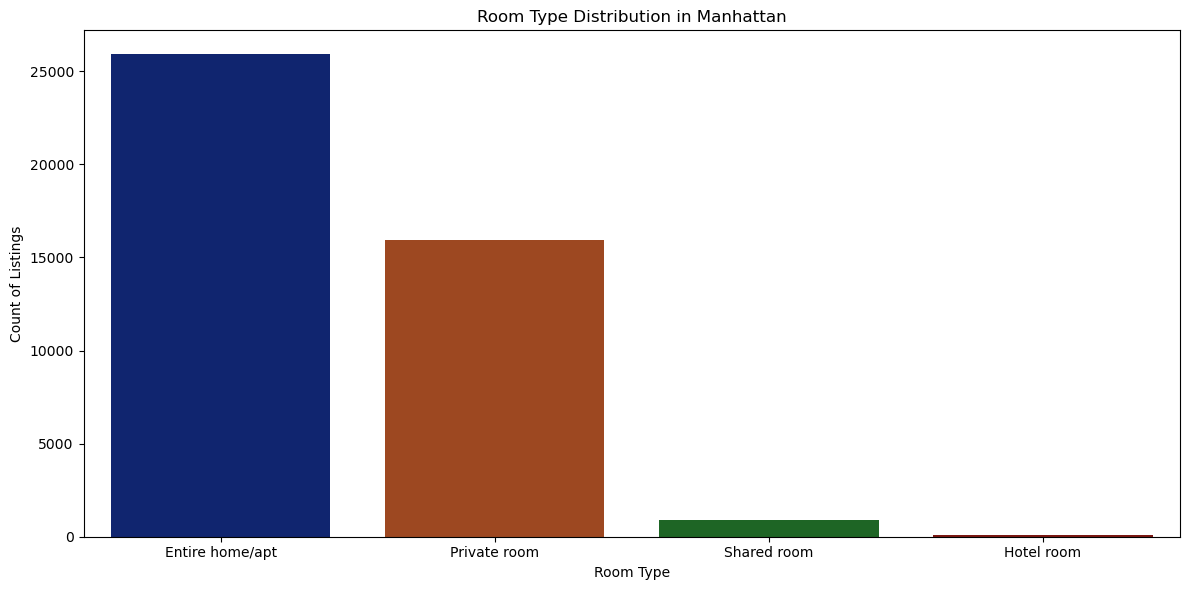

In [821]:
manhattan_data = df_dt[df_dt['neighbourhood_group_Manhattan'] == 1]

# Plot the Room Type Distribution in Manhattan
plt.figure(figsize=(12, 6))
sns.countplot(
    data=manhattan_data,
    x='room_type',
    palette='dark',
    order=manhattan_data['room_type'].value_counts().index
)
plt.title('Room Type Distribution in Manhattan')
plt.xlabel('Room Type')
plt.ylabel('Count of Listings')
plt.tight_layout()
plt.show()


- Actionable Insight:
- Use neighborhood demand and review patterns to guide room offerings and marketing strategies.

# Plotly Map to create a scatter mapbox plot 

In [824]:
df_map = df.copy()

In [825]:
import plotly.express as px
px.set_mapbox_access_token ='pk.eyJ1IjoidGxvbmUiLCJhIjoiY200NHY2azc5MGI2ODJrcHgwMnEwbXdlOSJ9.uIE0l3o1-lyeS0BlHOZkJQ'
fig = px.scatter_mapbox(data_frame=df_map, 
                        lat="lat", 
                        lon="long",
                        color="price",
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                       )
fig.update_layout(mapbox_style="carto-positron",\
                  mapbox_zoom=8, mapbox_center = {"lat": 40.7128, "lon": -74.0060})

- This graph will display a scatterplot centered around New York City
- We have used new licence of Ploty
- X-axis and Y-axis: Represent longitude and latitude, respectively.
- Color: Encodes the price values. Points with different prices will appear in different colors along the cyclical color scale.
- set_mapbox_access_token token is newly generated token.
- There is a wide range of prices scatterd all over the neighborhoods of New York
- The neighborhoods where the tourist attractions like Central park, Empire State Building and Statue of Liberty are located have higher density of listings

#### Managerial recommenations:
- Price adjustments should be considered based calculated price delta which is based on neighborhood mean
- Dynamic Pricing strategies. Adjust pricing models based on market demand to optimize revenue during peak seasons.
- Use neighborhood demand and review patterns to guide room offerings and marketing strategies.

##### Additional Recommendation:
- The neighborhoods adjacent to Manhattan and Brooklyn have lower density of listings, there is potential to expand in these areas.